<h1>APPLICATION DE L'ALGORITHME XGBOOST SUR LA BASE DES EXEMPLES ARCENE

<H2>1-CREATION DE NOTRE PROPRE MODELE:

<h3>1-1Outils nécessaire pour la creation de modèle XGBoost

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor #Création des arbre de décision avec le modèle sklearn

<h4>1-1-1La fonction de perte:

Pour entraîner le modèle, nous devons optimiser une fonction de perte. Généralement, nous utilisons l'erreur quadratique moyenne racinée (Rooted Mean Squared Error) pour la régression, la perte logarithmique (LogLoss) pour la classification binaire, et la perte logarithmique multiclasse (mlogloss) pour la classification multiclasse.<br> 
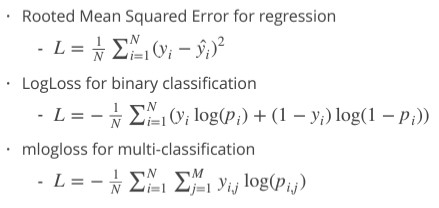

Pour notre cas, nous devons utiliser la perte logarithmique (LogLoss) pour la classification binaire en raison du type de cible dans l'ensemble de données ARCENE.

In [2]:
def logLoss(y,p):
    N=len(y)
    L=(-1/N) * np.sum(y * np.log(p) + (1-y) * np.log(1-p))
    return L

N : nombre total d'étiquettes pour les classes.<br>
y : véritables étiquettes des classes (0 pour négatif, 1 pour positif).<br>
p : prédiction du modèle (estimation des probabilités calculée avec la fonction sigmoïde).<br>

<h4>1-1-2Calcule de probabilités éstimée avec La fonction sigmoid

In [3]:
def sigmoid(W):
    #print("Values of W:", W)
    return 1/(1+np.exp(-W))

<h4>1-1-3Terme de régularisation

La régularisation est une autre partie importante du modèle. Un terme de régularisation bien choisi contrôle la complexité du modèle, ce qui empêche le surajustement (overfitting).
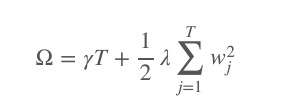
où T est le nombre de feuilles, et Wj**2 est le score sur la j-ème feuille.

In [4]:
def RegularizationTerm(weights,lambda_val = 0.01, Regul_type = 'l2'):
    if Regul_type == 'l1':#lasso regularization
        return (1/2)*lambda_val * np.sum(np.abs(weights[1:]))
    elif Regul_type == 'l2':#Ridge regularization
        return (1/2)*lambda_val * np.sum(weights**2)
    else:
        return 0

<h4>1-1-4La fonction Objectif du modèle XGB

En combinant la fonction de perte et la régularisation, nous obtenons l'objectif du modèle : 
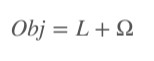
Là où la fonction de perte contrôle la puissance prédictive, et la régularisation contrôle la simplicité.

In [5]:
def Obj(X, y, weights,lambda_val, Regul_type):
    p = sigmoid(np.dot(X, weights))
    cost = logLoss(y,p)
    regularization_term = RegularizationTerm(weights,lambda_val, Regul_type)
    cost += regularization_term
    return cost

Dans XGBoost, nous utilisons la descente de gradient pour optimiser l'objectif. Étant donné un objectif Obj(y, yˆ) à optimiser, la descente de gradient est une technique itérative qui calcule
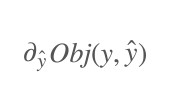
à chaque itération. Ensuite, nous améliorons les Résidus le long de la direction du gradient pour minimiser l'objectif.

In [6]:
def gradient_desc(y_true, y_pred):
    gradient = -(y_true / y_pred - (1 - y_true) / (1 - y_pred))
    return gradient


Rappelons la définition de l'objectif Obj=L+Ω. Pour un algorithme itératif, nous pouvons redéfinir la fonction objective comme
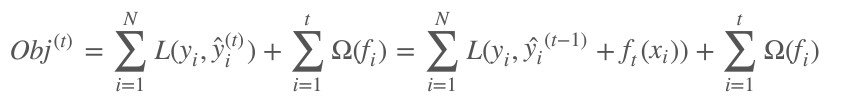
Pour l'optimiser par la descente de gradient, nous devons calculer le gradient. La performance peut également être améliorée en considérant à la fois le gradient du premier et du deuxième ordre.

<h3>1-2 L'algorithme de construction d'arbre

Les structures arborescentes dans XGBoost posent le problème central : comment pouvons-nous trouver un arbre qui améliore la prédiction le long du gradient ?

Chaque arbre de décision ressemble à ceci :
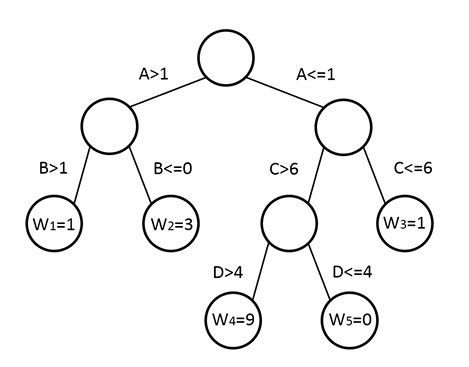    
Chaque point de données se dirige vers l'une des feuilles en suivant la direction de chaque nœud.
Les concepts fondamentaux sont :<br>
· Nœuds internes<br>
__Chaque nœud interne divise le flux de points de données en fonction d'une des caractéristiques. <br>
__La condition sur l'arête spécifie quelles données peuvent circuler à travers.<br>
· Feuilles<br>
__Les points de données qui atteignent une feuille se verront attribuer un poids. <br>
__Le poids est la prédiction.<br>

<h3>1-3 L'entrainement de modèle:

In [7]:
def train_xgboost(X, y, n_estimators, learning_rate, max_depth, lambda_val, regul_type='l1'):
    m, n = X.shape
    
    # Ajout d'un terme constant pour le biais
    X_augmented = np.concatenate((np.ones((m, 1)), X), axis=1)
    
    # Initialisation des poids et de la liste des arbres
    weights = np.zeros(n + 1)
    trees = []

    for i in range(n_estimators):
        # Calcul des probabilités prédites
        W = np.dot(X_augmented, weights)
        y_pred_prob = sigmoid(W)

        # Vérification des NaN ou de l'infini dans les prédictions
        if np.isnan(y_pred_prob).any() or np.isinf(y_pred_prob).any():
            raise ValueError("NaN or infinity encountered in predictions. Check your data and model parameters.")

        # Calcul du gradient en utilisant gradient_desc
        error = gradient_desc(y, y_pred_prob)#calcul des résidus
        gradients = (1 / m) * np.dot(X_augmented.T, error)
        
        # Mise à jour des poids
        weights -= learning_rate * gradients

        # Calcul et affichage du coût pour le suivi de la convergence
        cost = Obj(X_augmented, y, weights, lambda_val, regul_type)
        if np.isnan(cost):
            raise ValueError("NaN encountered in cost. Check your data and model parameters.")
        print(f'Iteration {i + 1}/{n_estimators}, Cost: {cost}')

        # Construction d'un arbre de décision en utilisant les résidus négatifs comme étiquettes
        tree = DecisionTreeRegressor(max_depth=max_depth)
        tree.fit(X, -error)
        trees.append(tree)

    return weights, trees

<h3>1-4 Test de modèle:

In [8]:
def predict_xgboost(X, trees, learning_rate):
    # Ajout d'un terme constant pour le biais
    m, _ = X.shape
    X_augmented = np.concatenate((np.ones((m, 1)), X), axis=1)
    
    # Initialisation des prédictions
    predictions = np.zeros(m)

    # Prédiction à l'aide de chaque arbre avec le taux d'apprentissage
    for tree in trees:
        predictions += learning_rate * tree.predict(X)

    return sigmoid(predictions)

<h3>1-5 Calcule de la précision de modèle:

In [9]:
# Calculer la précision en comparant les valeurs réelles aux valeurs prédites
def calculate_accuracy(y_true, y_pred):
    y_pred_class = np.round(y_pred)
    accuracy = np.mean(y_true == y_pred_class)
    return accuracy

<h3>1-6 Application sur la base des exemples ARCENE:

In [10]:
import pandas as pd

#------------------------------------------Chargement des données d'entrainement------------------------------------------------

# Spécifiez les chemins des fichiers de données d'entrainement et d'étiquettes
data_file_path = "C:/Users/pc/Desktop/MASTER IASD/S1/MACHINE LEARNING 1/mini-projet/ARCENE/arcene_train.data"
labels_file_path = "C:/Users/pc/Desktop/MASTER IASD/S1/MACHINE LEARNING 1/mini-projet/ARCENE/arcene_train.labels"

# Chargez les données et les étiquettes
data = pd.read_csv(data_file_path, sep=" ", header=None)
labels = pd.read_csv(labels_file_path, header=None)
# Supprimez la dernière colonne des données, qui contient des NaN
data = data.iloc[:, :-1]

# Fusionnez les données et les étiquettes pour former un ensemble de données complet
dataset = pd.concat([data, labels], axis=1)

# Ajoutez des noms d'attributs (supposant qu'ils sont nommés "Génes_i")
attribute_names = [f"Géne_{i}" for i in range(1, data.shape[1] + 1)]
dataset.columns = attribute_names + ['Résultats']

# Changez les étiquettes cibles de -1 à 0
dataset['Résultats'] = dataset['Résultats'].replace(-1, 0)

#------------------------------------------Chargement des données de test (validation)------------------------------------------
# Répétition de mêmes étapes:
data_valid_file_path = "C:/Users/pc/Desktop/MASTER IASD/S1/MACHINE LEARNING 1/mini-projet/ARCENE/arcene_valid.data"
labels_valid_file_path = "C:/Users/pc/Desktop/MASTER IASD/S1/MACHINE LEARNING 1/mini-projet/ARCENE/arcene_valid.labels"


data_valid = pd.read_csv(data_valid_file_path, sep=" ", header=None)
labels_valid = pd.read_csv(labels_valid_file_path, header=None)
data_valid = data_valid.iloc[:, :-1]
dataset_valid = pd.concat([data_valid, labels_valid], axis=1)
attribute_names = [f"Géne_{i}" for i in range(1, data_valid.shape[1] + 1)]
dataset_valid.columns = attribute_names + ['Résultats']
dataset_valid['Résultats'] = dataset_valid['Résultats'].replace(-1, 0)

In [11]:
dataset.head(100)

,Géne_1,Géne_2,Géne_3,Géne_4,Géne_5,Géne_6,Géne_7,Géne_8,Géne_9,Géne_10,...,Géne_9992,Géne_9993,Géne_9994,Géne_9995,Géne_9996,Géne_9997,Géne_9998,Géne_9999,Géne_10000,Résultats
0,0,71,0,95,0,538,404,20,0,0,...,570,86,0,36,0,80,0,0,524,1
1,0,41,82,165,60,554,379,0,71,0,...,605,69,7,473,0,57,0,284,423,0
2,0,0,1,40,0,451,402,0,0,0,...,593,28,0,24,0,90,0,34,508,1
3,0,56,44,275,14,511,470,0,0,0,...,600,0,26,86,0,102,0,0,469,1
4,105,0,141,348,0,268,329,0,0,1,...,0,0,0,0,190,301,0,0,354,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,24,26,0,461,0,545,0,17,159,177,...,460,22,26,130,306,182,0,94,336,0
96,40,0,0,419,71,502,0,39,93,163,...,436,0,68,61,295,133,0,0,292,0
97,2,15,48,677,0,434,442,0,43,0,...,628,0,7,228,0,105,0,0,453,1
98,8,0,38,205,69,419,454,0,113,3,...,587,148,27,656,0,133,0,189,403,0


In [12]:
dataset_valid.head(100)

,Géne_1,Géne_2,Géne_3,Géne_4,Géne_5,Géne_6,Géne_7,Géne_8,Géne_9,Géne_10,...,Géne_9992,Géne_9993,Géne_9994,Géne_9995,Géne_9996,Géne_9997,Géne_9998,Géne_9999,Géne_10000,Résultats
0,0,0,156,138,2,635,444,0,1,0,...,692,42,0,50,67,87,0,0,465,0
1,0,7,0,7,0,251,0,0,22,222,...,673,0,0,18,201,317,0,34,199,0
2,0,32,0,470,53,493,0,0,140,147,...,461,20,34,165,225,53,0,47,219,0
3,0,77,0,202,0,432,472,0,60,0,...,555,13,0,488,0,71,0,177,487,1
4,0,34,102,522,2,474,473,0,39,0,...,630,0,29,192,0,74,0,5,416,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,24,73,0,436,92,400,0,0,139,261,...,540,0,86,130,365,58,17,3,37,0
96,11,58,50,332,109,393,122,0,75,134,...,355,156,77,26,277,265,0,36,261,0
97,93,32,137,319,0,264,231,21,0,0,...,9,0,0,0,244,309,0,276,312,1
98,119,12,198,339,0,289,410,0,0,4,...,0,37,0,0,256,402,0,0,350,1


In [13]:
#Transformation des tables de pd à des np array pour l'utiliser:
#Données d'entrainement:-------------------------------------------------------------------------------------------------
DS=np.array(dataset)
data_train=DS[:,:-1]#table de données d'entrainement
labels_train=np.array(dataset)[:,-1]#table des étiquettes de données d'entrainement

#Données de test:--------------------------------------------------------------------------------------------------------
DS_valid=np.array(dataset_valid)
dataa_valid=DS_valid[:,:-1]
labelss_valid=np.array(dataset_valid)[:,-1]

In [14]:
data_train

array([[  0,  71,   0, ...,   0,   0, 524],
       [  0,  41,  82, ...,   0, 284, 423],
       [  0,   0,   1, ...,   0,  34, 508],
       ...,
       [  2,  15,  48, ...,   0,   0, 453],
       [  8,   0,  38, ...,   0, 189, 403],
       [  0,   0,   0, ...,   0,  10, 365]], dtype=int64)

In [15]:
labels_train

array([1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1], dtype=int64)

In [16]:
dataa_valid

array([[  0,   0, 156, ...,   0,   0, 465],
       [  0,   7,   0, ...,   0,  34, 199],
       [  0,  32,   0, ...,   0,  47, 219],
       ...,
       [ 93,  32, 137, ...,   0, 276, 312],
       [119,  12, 198, ...,   0,   0, 350],
       [112,  19, 171, ...,   0,   0, 367]], dtype=int64)

In [17]:
labelss_valid

array([0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0], dtype=int64)

<bold>Informations sur l'ensemble de données ARCENE provenant du site officiel</bold> https://archive.ics.uci.edu/dataset/167/arcene <br>

ARCENE a été obtenu en fusionnant trois ensembles de données de spectrométrie de masse afin d'obtenir suffisamment de données d'entraînement et de test pour un banc d'essai. Les caractéristiques d'origine indiquent l'abondance des protéines dans le sérum humain ayant une valeur de masse donnée. Sur la base de ces caractéristiques, il est nécessaire de séparer les patients atteints de cancer des patients en bonne santé. Nous avons ajouté un certain nombre de caractéristiques de distraction appelées 'probes' n'ayant aucun pouvoir prédictif. L'ordre des caractéristiques et des motifs a été randomisé.
<br>
Nombre de variables/caractéristiques/attributs :<br>
Réelles : 7000<br>
Probes : 3000<br>
Total : 10000<br>

<H5>Nous allons donc supprimer les 3000 colonnes qui ont la plus petite valeur de variance.</H5> <br>

Ce code calcule les variances de chaque colonne dans un ensemble de données d'entraînement, trie ces variances par ordre croissant, puis sélectionne les indices des 3000 colonnes ayant les plus petites variances. Ces indices représentent les colonnes à supprimer pour réduire la dimensionnalité des données.

In [18]:
# Création d'un dictionnaire pour stocker les variances de chaque colonne
var_list={}
# Calcul des variances pour chaque colonne dans les données d'entraînement
for i in range(len(data_train[0])):
    var_list[i]=np.var(data_train[:,i])
# Tri du dictionnaire par valeurs de variance croissantes
var_list_trie = dict(sorted(var_list.items(), key=lambda item: item[1]))
# Sélection des indices des 3000 colonnes avec les plus petites variances
index_to_remove=list(var_list_trie.keys())[:3000]
len(index_to_remove)

3000

In [19]:
#modification sur les données:
modified_data_train = np.delete(data_train , index_to_remove, axis=1)
modified_data_valid = np.delete(dataa_valid , index_to_remove, axis=1)

In [20]:
modified_data_train

array([[  0,  71,   0, ...,  80,   0, 524],
       [  0,  41,  82, ...,  57, 284, 423],
       [  0,   0,   1, ...,  90,  34, 508],
       ...,
       [  2,  15,  48, ..., 105,   0, 453],
       [  8,   0,  38, ..., 133, 189, 403],
       [  0,   0,   0, ..., 210,  10, 365]], dtype=int64)

In [21]:
modified_data_valid

array([[  0,   0, 156, ...,  87,   0, 465],
       [  0,   7,   0, ..., 317,  34, 199],
       [  0,  32,   0, ...,  53,  47, 219],
       ...,
       [ 93,  32, 137, ..., 309, 276, 312],
       [119,  12, 198, ..., 402,   0, 350],
       [112,  19, 171, ..., 379,   0, 367]], dtype=int64)

<h3>1-7 Détermination des performence de modèle:

In [22]:
# Entraînement du modèle XGBoost
weights1, trees1 = train_xgboost(modified_data_train, labels_train, n_estimators=105, learning_rate=10**-9, max_depth=100, lambda_val=0.01)

# Prédiction sur les données de test
predictions = predict_xgboost(modified_data_valid,trees1, learning_rate=10**-9)
print(predictions)

#Calcul de la précision de notre modéle
accuracy = calculate_accuracy(labelss_valid, predictions)
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

Iteration 1/105, Cost: 0.6885341881435337
Iteration 2/105, Cost: 0.6846428484998295
Iteration 3/105, Cost: 0.6812971067565522
Iteration 4/105, Cost: 0.6783694639075503
Iteration 5/105, Cost: 0.6757668043188938
Iteration 6/105, Cost: 0.6734205833269596
Iteration 7/105, Cost: 0.6712799501617
Iteration 8/105, Cost: 0.6693068769994202
Iteration 9/105, Cost: 0.6674726767452621
Iteration 10/105, Cost: 0.6657555053540489
Iteration 11/105, Cost: 0.6641385566000327
Iteration 12/105, Cost: 0.6626087474457937
Iteration 13/105, Cost: 0.661155764002227
Iteration 14/105, Cost: 0.6597713642089867
Iteration 15/105, Cost: 0.6584488618241396
Iteration 16/105, Cost: 0.6571827502383571
Iteration 17/105, Cost: 0.6559684231165618
Iteration 18/105, Cost: 0.6548019684029884
Iteration 19/105, Cost: 0.653680010986529
Iteration 20/105, Cost: 0.6525995994465575
Iteration 21/105, Cost: 0.6515581210010634
Iteration 22/105, Cost: 0.6505532337174988
Iteration 23/105, Cost: 0.6495828188022027
Iteration 24/105, Cost: 0

<h3>1-8 Application de la validation croisée sur dataset ARCENE:  

La validation croisée est une méthode permettant de tester les performances d'un modèle prédictif d'apprentissage automatique. Découvrez les techniques les plus couramment utilisées et apprenez à les maîtriser. Après avoir entraîné un modèle d'apprentissage automatique sur des données étiquetées, il est censé fonctionner sur de nouvelles données.

Maintenant, nous devons concaténer les données d'entraînement avec les données de validation afin de les diviser et d'appliquer la méthode de validation croisée :

In [23]:
# Concaténer les données d'entraînement avec les données de validation
new_data=np.concatenate((modified_data_train,modified_data_valid),axis=0)
new_labels=np.concatenate((labels_train,labelss_valid),axis=0)

# Concaténer les nouvelles données avec les nouvelles étiquettes
glob_new_dataset=np.concatenate((new_data,new_labels.reshape(-1, 1)),axis=1)

# Diviser les données en 5 ensembles
folds={}
for i in range(0,200,40):
    folds[int(i/40)]=glob_new_dataset[i:i+40,:]
    
data = []
for key in folds:
    fold_data = folds[key]
    data.append(fold_data)

X = np.concatenate(data, axis=0)[:,:-1]
y = np.concatenate(data, axis=0)[:,-1]

# Définir le nombre de ensemble
num_folds = 5

# Calculer la taille de chaque ensemble
fold_size = len(X) // num_folds

fold_accuracies = []

# Effectuer la validation croisée
for i in range(num_folds):
    # Diviser les données en ensembles d'entraînement et de test 
    test_start = i * fold_size
    test_end = (i + 1) * fold_size
    X_test = X[test_start:test_end]
    y_test = y[test_start:test_end]
    
    # Utiliser le reste des données pour l'entraînement
    X_train = np.concatenate([X[:test_start], X[test_end:]], axis=0)
    y_train = np.concatenate([y[:test_start], y[test_end:]], axis=0)
    
    # Entraînement du modèle XGBoost
    we, tr = train_xgboost(X_train,y_train, n_estimators=20, learning_rate=10**-9, max_depth=100, lambda_val=0.01)
    
    # Faire des prédictions sur l'ensemble de test
    y_pred = predict_xgboost(X_test,tr, learning_rate=10**-9)
    
    # Évaluer le modèle
    accuracy = calculate_accuracy(y_test, y_pred)
    fold_accuracies.append(accuracy)
    print(f"_________FIN {i+1}_________")

# Calculer et afficher la précision moyenne à travers les ensembles
average_accuracy = np.mean(fold_accuracies)
print(fold_accuracies)
print(f'Average Accuracy: {average_accuracy* 100:.2f} %')


Iteration 1/20, Cost: 0.6887391425296749
Iteration 2/20, Cost: 0.6848213117592356
Iteration 3/20, Cost: 0.6812827094624478
Iteration 4/20, Cost: 0.6780428489817119
Iteration 5/20, Cost: 0.6750428049422736
Iteration 6/20, Cost: 0.6722390226930725
Iteration 7/20, Cost: 0.6695989834502662
Iteration 8/20, Cost: 0.6670981421535597
Iteration 9/20, Cost: 0.6647177510058545
Iteration 10/20, Cost: 0.6624432998460622
Iteration 11/20, Cost: 0.6602633972225813
Iteration 12/20, Cost: 0.6581689605057266
Iteration 13/20, Cost: 0.656152629343141
Iteration 14/20, Cost: 0.6542083369099805
Iteration 15/20, Cost: 0.6523309957088358
Iteration 16/20, Cost: 0.650516268319828
Iteration 17/20, Cost: 0.6487603977196782
Iteration 18/20, Cost: 0.647060080797901
Iteration 19/20, Cost: 0.6454123728500681
Iteration 20/20, Cost: 0.6438146197631955
_________FIN 1_________
Iteration 1/20, Cost: 0.687123892138089
Iteration 2/20, Cost: 0.6819565035086058
Iteration 3/20, Cost: 0.6774351024041948
Iteration 4/20, Cost: 0.67

<h2>2- Utilisation du modèle XGBoost:

In [24]:
# Sans validation croisée
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Divisez les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertissez les données au format DMatrix pour XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Définissez les paramètres XGBoost avec le taux d'apprentissage, la régularisation L2 et la profondeur maximale
params = {
    'objective': 'binary:logistic',  # pour une classification binaire
    'eval_metric': 'error',  # utilisez l'erreur pour la précision de la classification binaire
    'lambda': 0.1,  # terme de régularisation L2
    'learning_rate': 0.1,  # taux d'apprentissage
    'max_depth': 100,  # profondeur maximale d'un arbre
}

# Entraînez le modèle XGBoost
num_rounds = 100  # You can adjust the number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)

# Faites des prédictions sur l'ensemble de test
y_pred = model.predict(dtest)

# Convertissez les probabilités prédites en prédictions binaires (0 ou 1)
y_pred_binary = np.round(y_pred)

# Calculez la précision
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 67.50%


In [25]:
#avec validation croisée
import xgboost as xgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

# Convertissez les données au format DMatrix pour XGBoost
dtrain = xgb.DMatrix(X, label=y)

# Définissez les paramètres XGBoost avec le taux d'apprentissage, la régularisation L2 et la profondeur maximale
params = {
    'objective': 'binary:logistic', 
    'eval_metric': 'error',  
    'lambda': 0.1,  
    'learning_rate': 0.01,  
    'max_depth': 100,  
}

# Nombre d'ensemble pour la validation croisée
num_folds = 5

# Effectuez la validation croisée
cv_results = cross_val_score(xgb.XGBClassifier(**params), X, y, cv=StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=100))

# Affichez les résultats
print(f'Cross-Validation Accuracy: {np.mean(cv_results) * 100:.2f}%')


Cross-Validation Accuracy: 77.50%
